### Generation of showers with CaloGAN per 10 Epoch

In [21]:
import keras
from keras.layers import Input, Lambda, Activation, AveragePooling2D, UpSampling2D
from keras.models import Model
from keras.layers.merge import multiply
import keras.backend as K

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm

latent_size = 1024
%cd /home/eren/CaloGAN/models/
from architectures import build_generator, build_discriminator, sparse_softmax
from ops import scale, inpainting_attention
%cd -

from scipy import stats
from scipy.optimize import curve_fit

from feats1d import *
plt.rcParams.update({'font.size': 20})
colors = plt.cm.gnuplot2(np.linspace(0.2, 0.8, 3))



/home/eren/CaloGAN/models
/home/eren/CaloGAN/analysis


In [3]:
import h5py
g = h5py.File('/home/eren/CaloGAN/data/gamma50GeV.hdf5', 'r')

## Loading Geant4 images
gamma = []
for j in range(5): 
    gamma.append(g['layer_{}'.format(j)][:50000])


vmin = [ gamma[k].mean(axis=0).min() for k in range(5)]
vmax = [ gamma[k].mean(axis=0).max() for k in range(5) ]

sizes = [gamma[0].shape[1], gamma[0].shape[2]] * 5

real_images_gamma = [gamma[k] for k in range(5)]

In [4]:
%ls /home/eren/CaloGAN/data | grep generator | grep nom > ~/epochW.txt

In [5]:
with open('/home/eren/epochW.txt', 'r') as f:
    epochs = [line.strip() for line in f]

In [6]:
for i in epochs:
    print (i.split('_')[-1][5:8])

000
010
020
030
040
050
060
070
080
090
100
110
120
130
140
150


In [19]:
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

Instructions for updating:
Colocations handled automatically by placer.
50000/50000 [==============================] - 96s 2ms/step
params_generator-Eph150-5lay-v2-Hyp_Bs256_L005_nomLR000.hdf5 855.338 133.04922


/software/anaconda3/5.2/lib/python3.6/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


50000/50000 [==============================] - 96s 2ms/step
params_generator-Eph150-5lay-v2-Hyp_Bs256_L005_nomLR010.hdf5 877.8335 78.17716
50000/50000 [==============================] - 99s 2ms/step
params_generator-Eph150-5lay-v2-Hyp_Bs256_L005_nomLR020.hdf5 874.08246 93.51355
50000/50000 [==============================] - 98s 2ms/step
params_generator-Eph150-5lay-v2-Hyp_Bs256_L005_nomLR030.hdf5 851.9689 108.96576
50000/50000 [==============================] - 99s 2ms/step
params_generator-Eph150-5lay-v2-Hyp_Bs256_L005_nomLR040.hdf5 850.4904 89.78408
50000/50000 [==============================] - 102s 2ms/step
params_generator-Eph150-5lay-v2-Hyp_Bs256_L005_nomLR050.hdf5 826.74994 88.046196
50000/50000 [==============================] - 110s 2ms/step
params_generator-Eph150-5lay-v2-Hyp_Bs256_L005_nomLR060.hdf5 895.6434 86.77124
50000/50000 [==============================] - 110s 2ms/step
params_generator-Eph150-5lay-v2-Hyp_Bs256_L005_nomLR070.hdf5 852.2744 84.92282
50000/50000 [=======

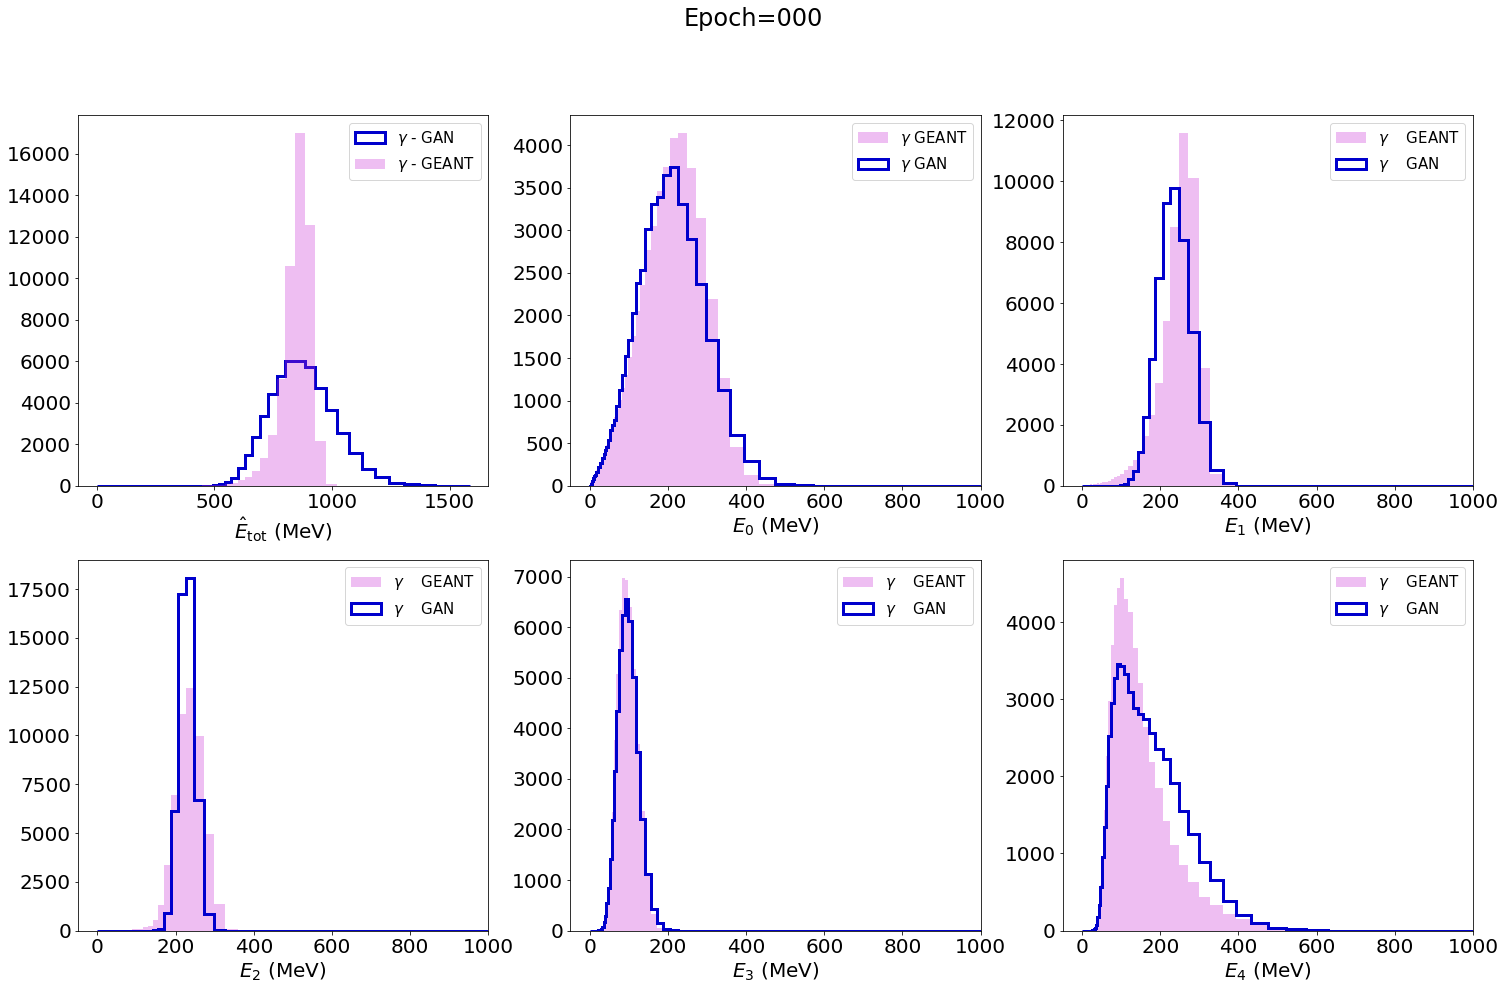

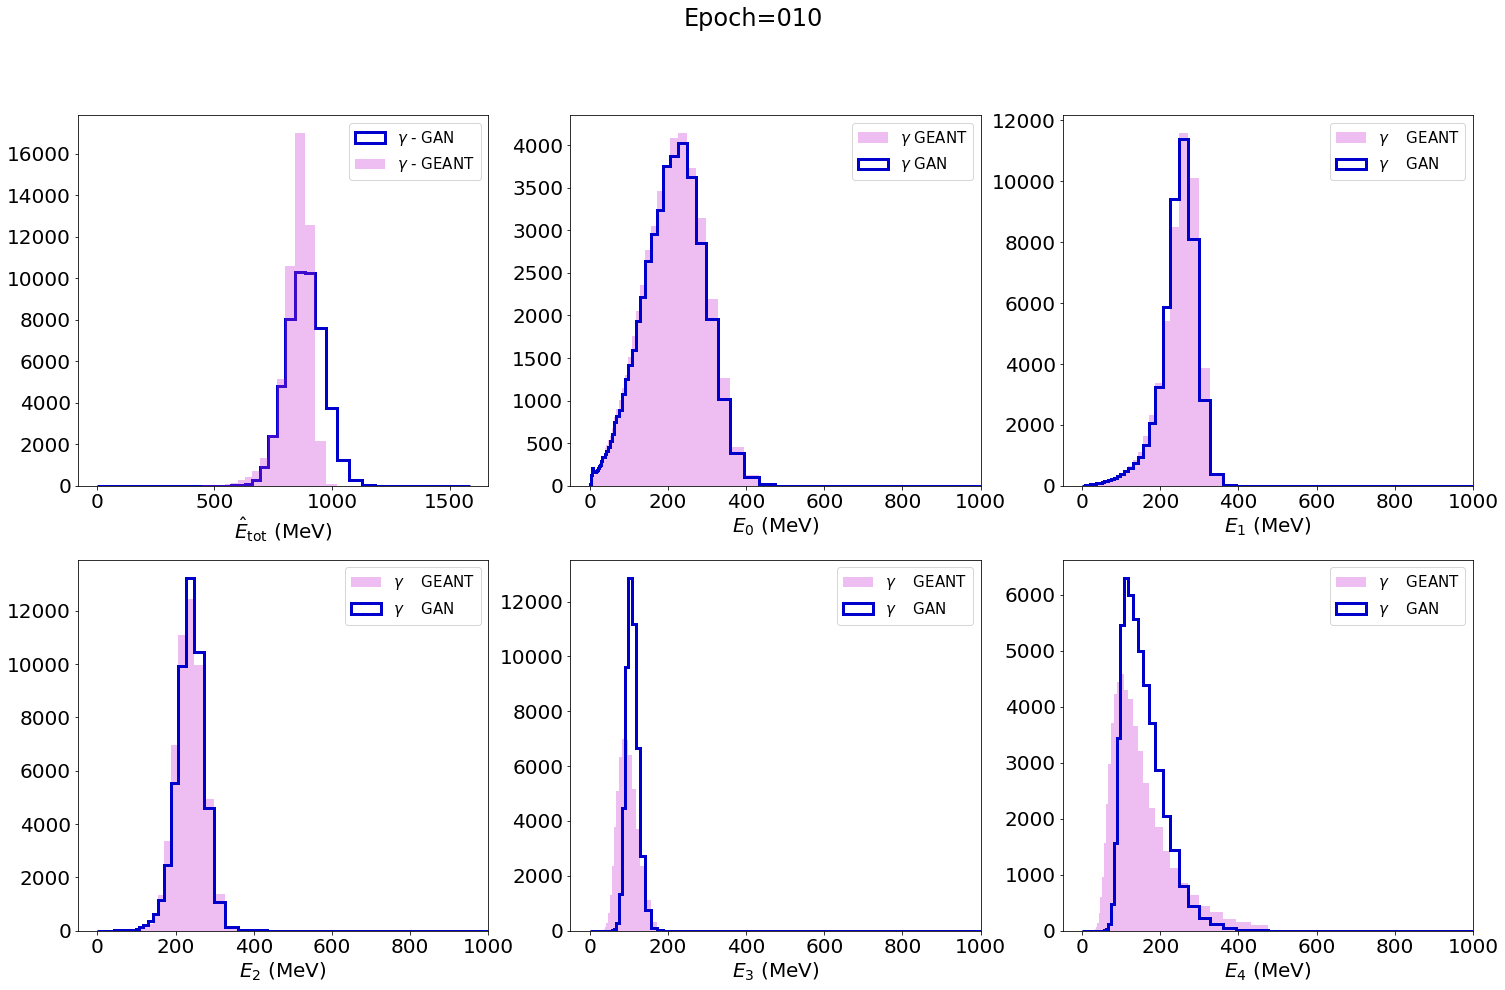

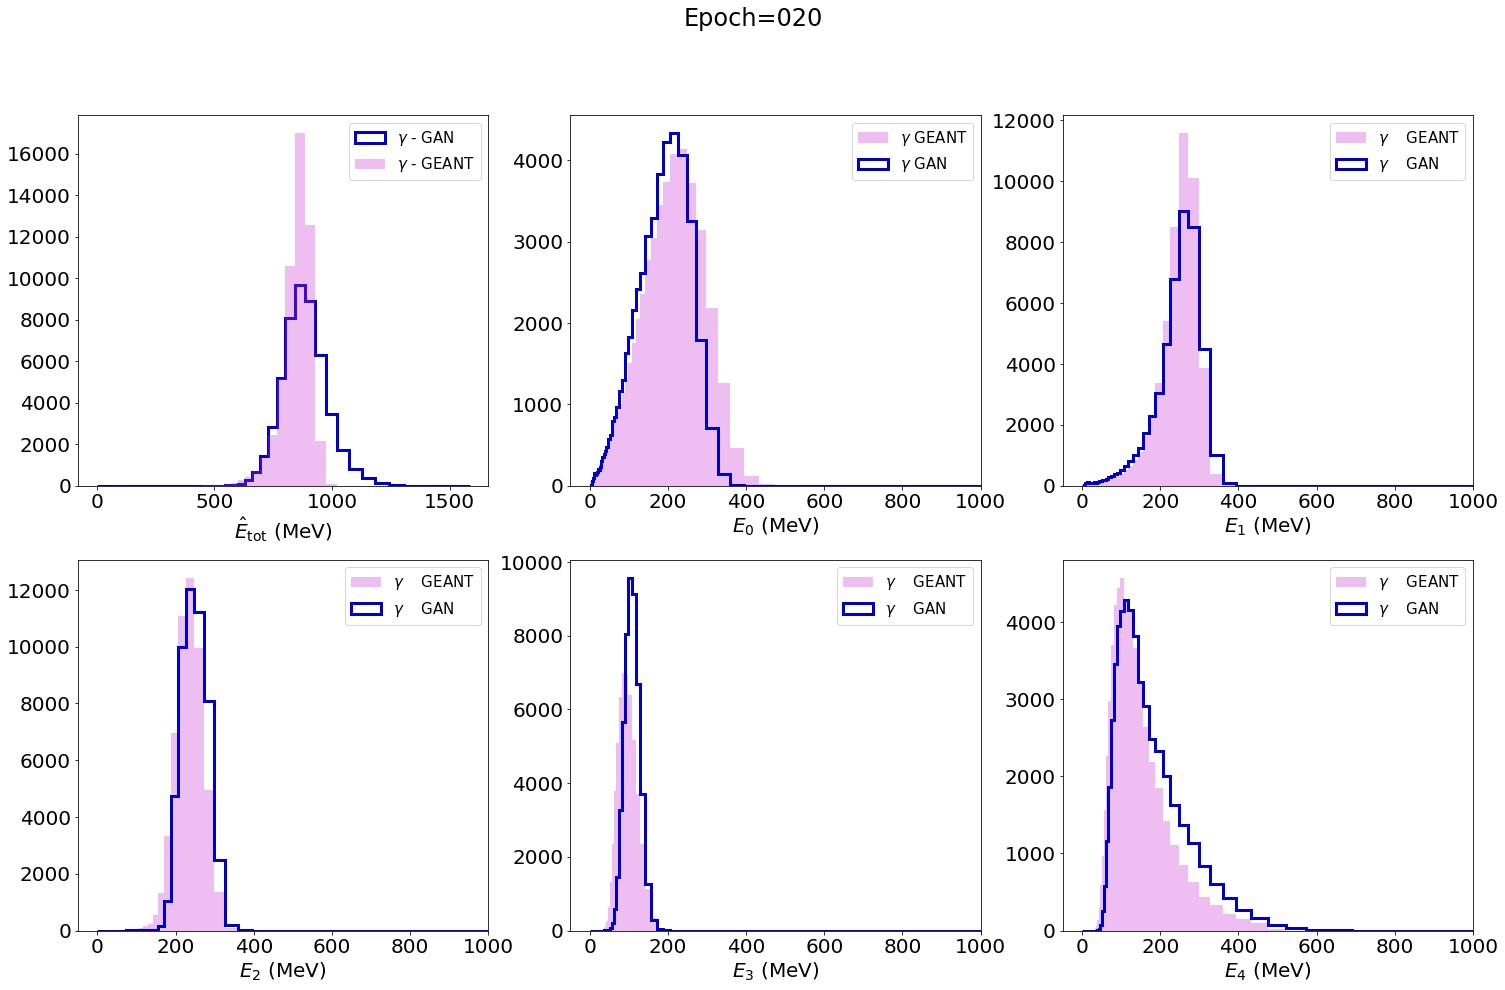

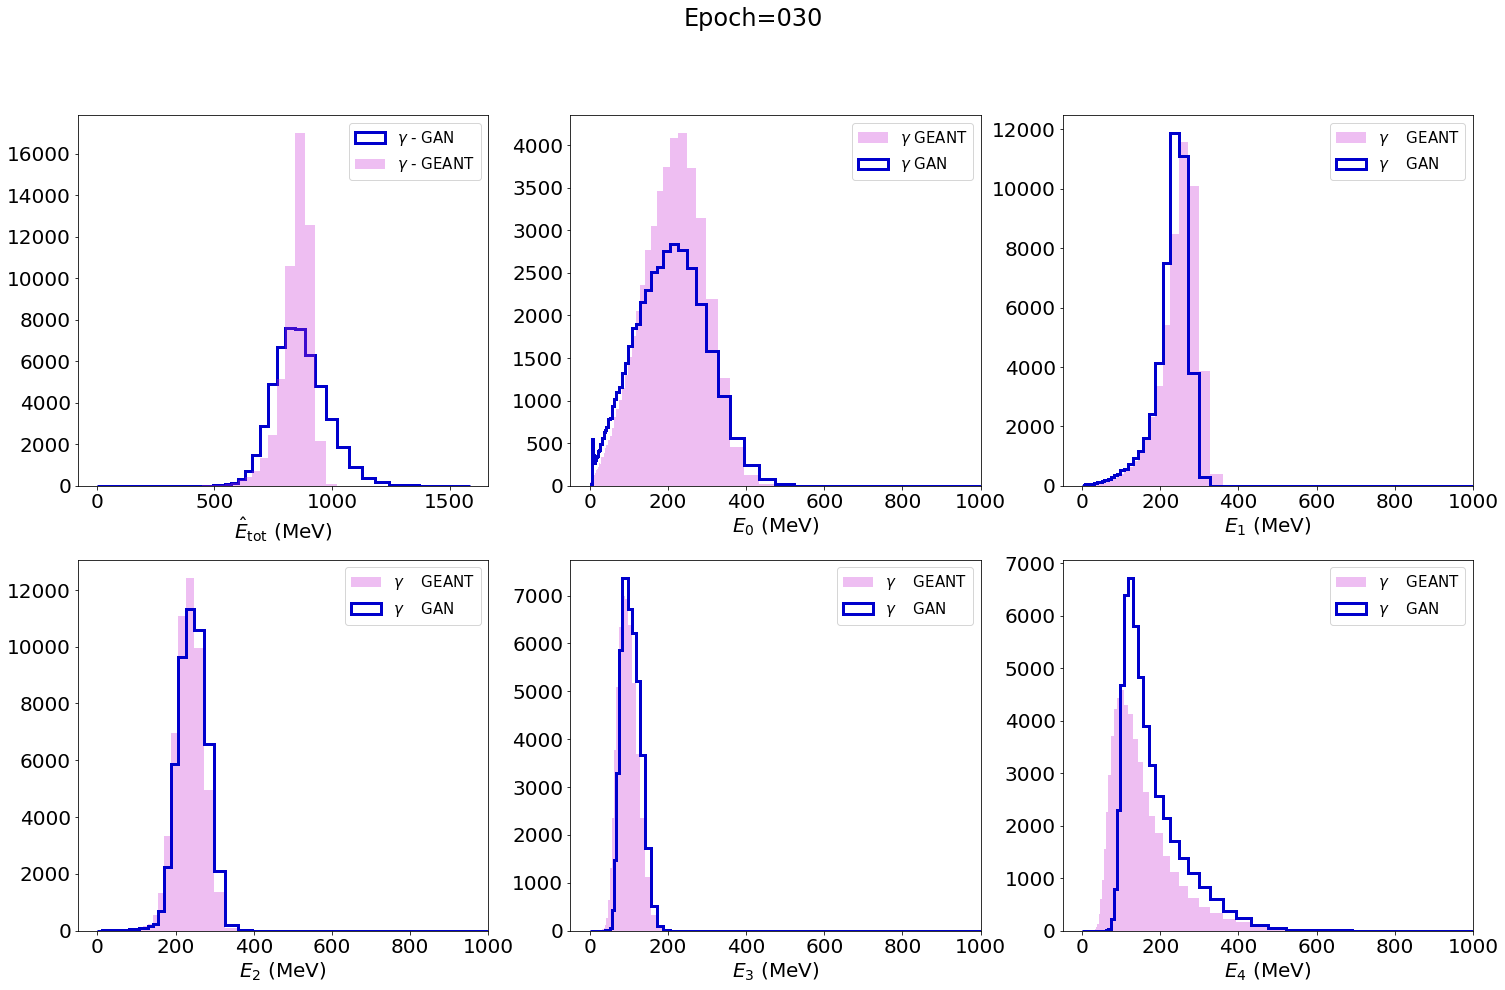

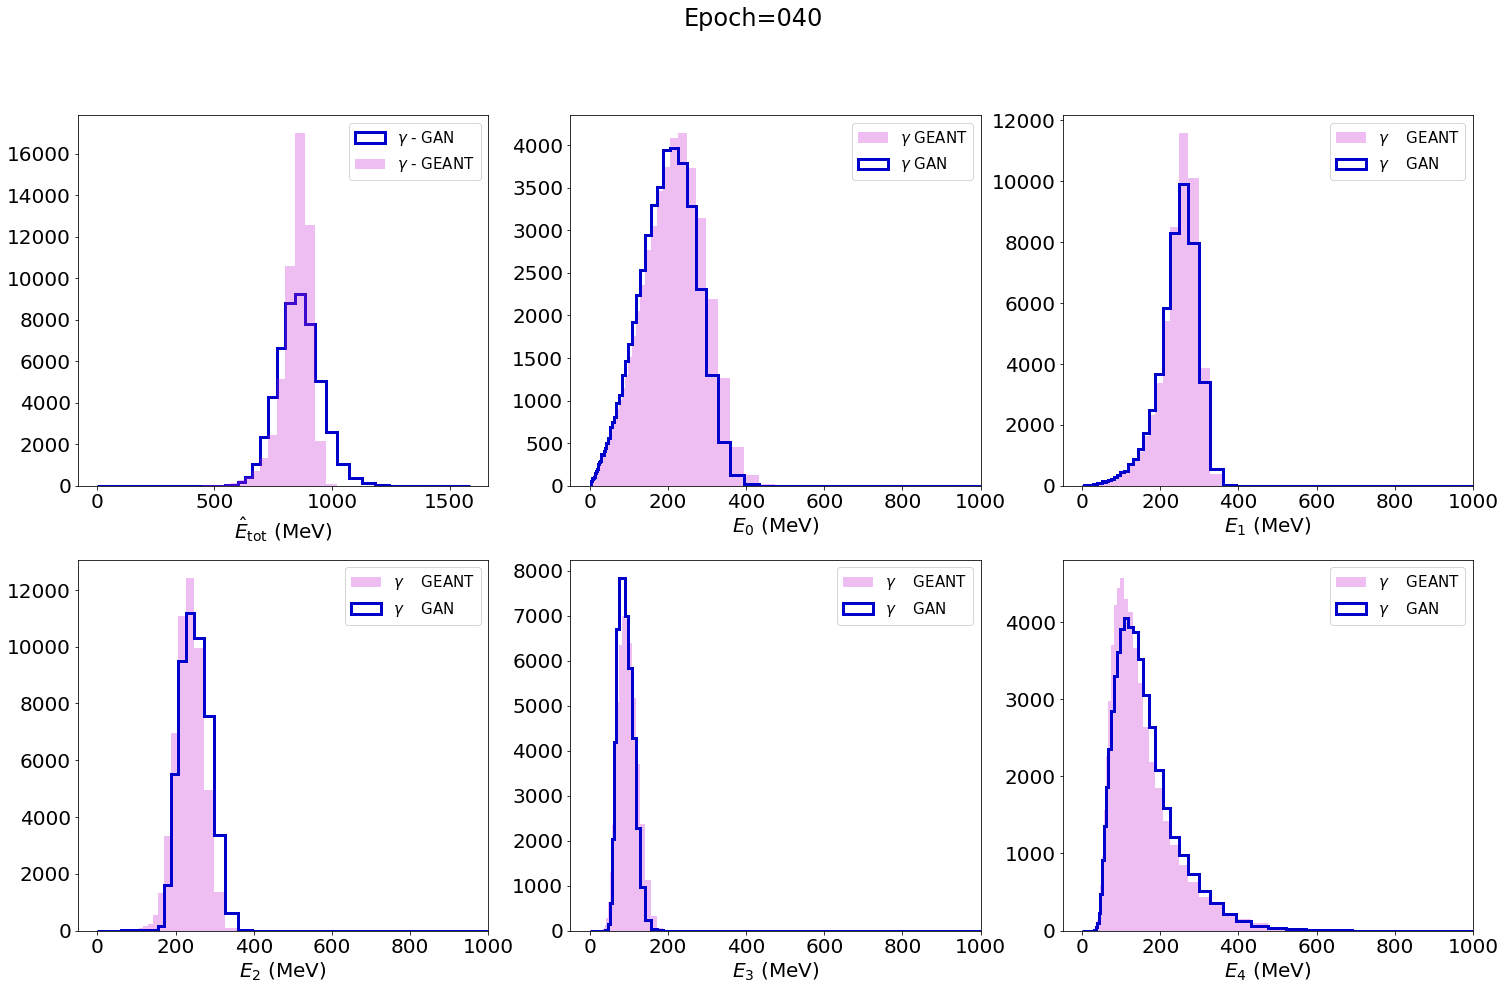

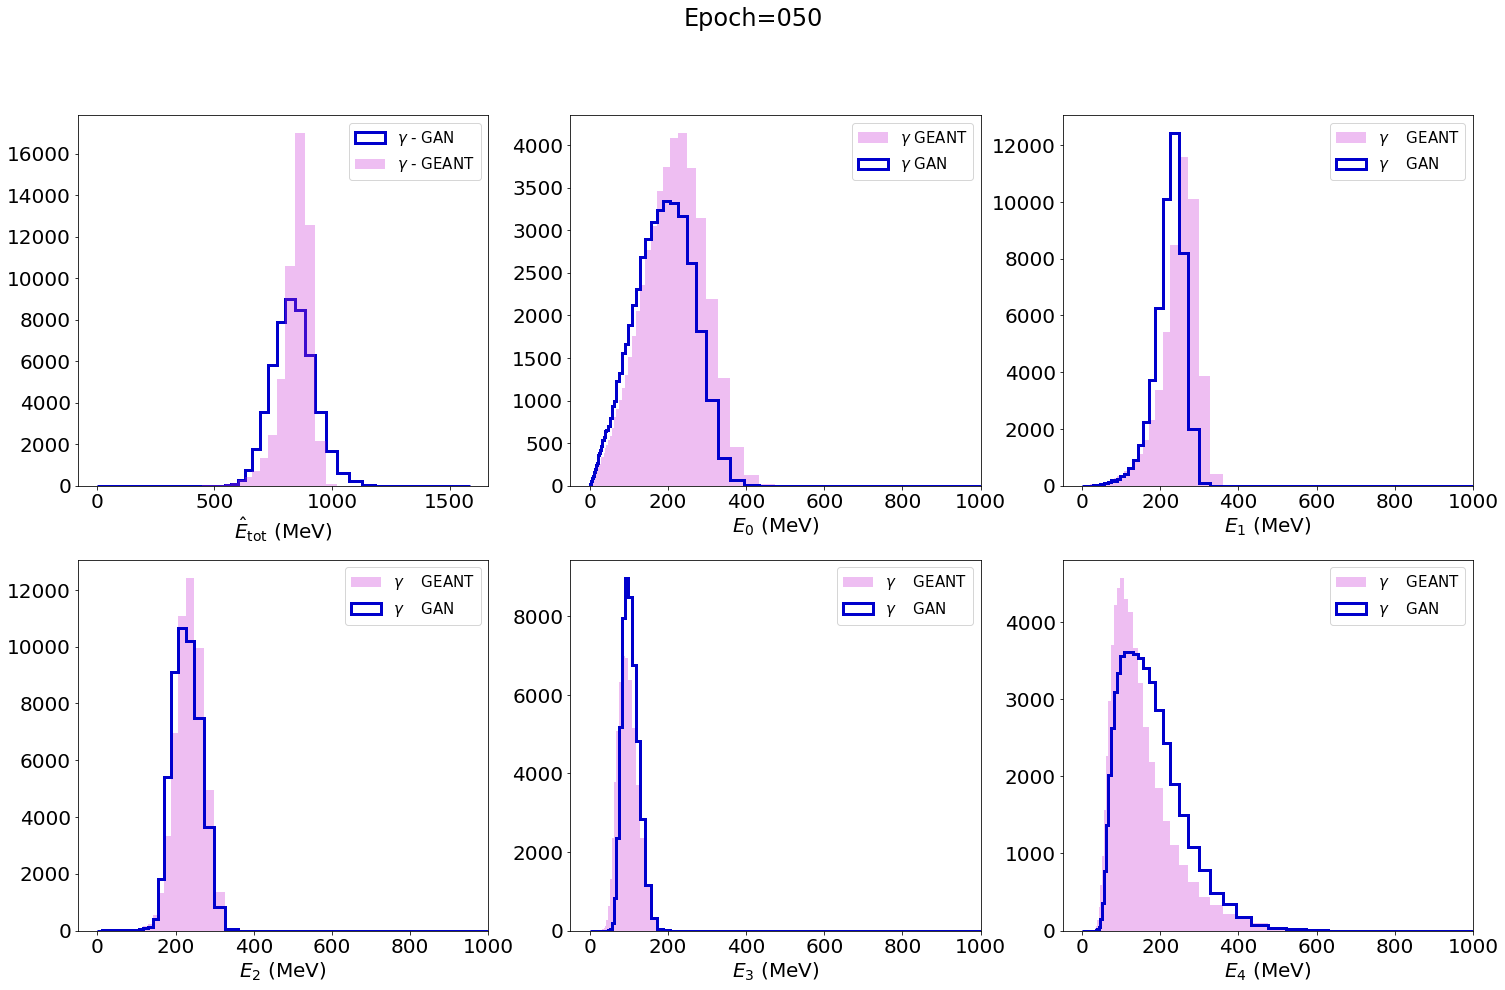

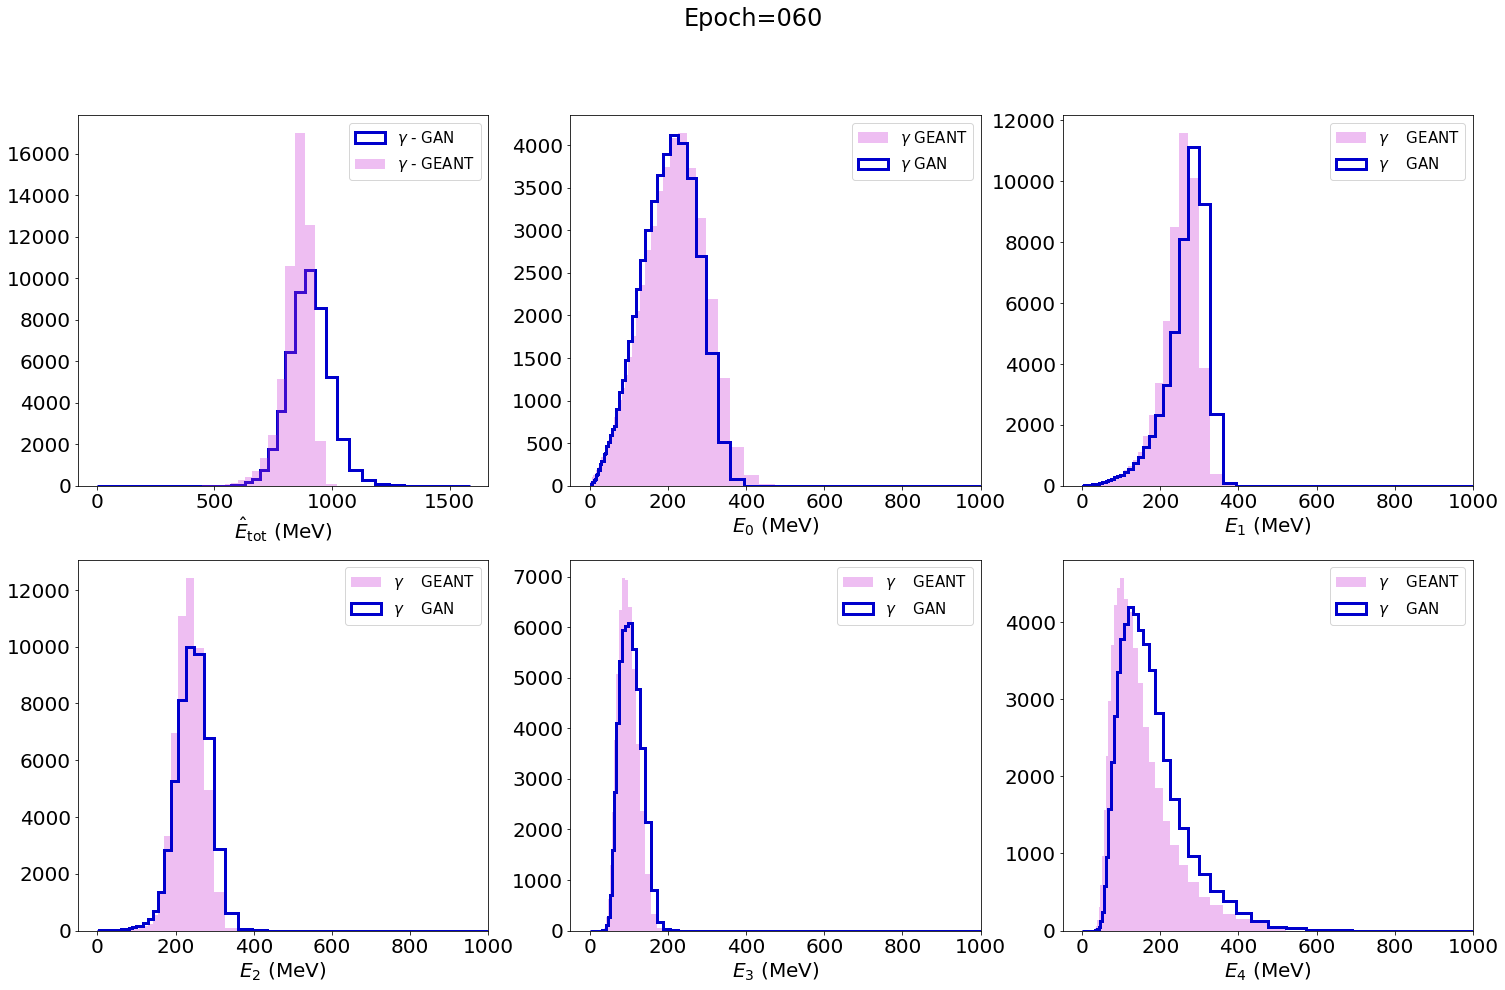

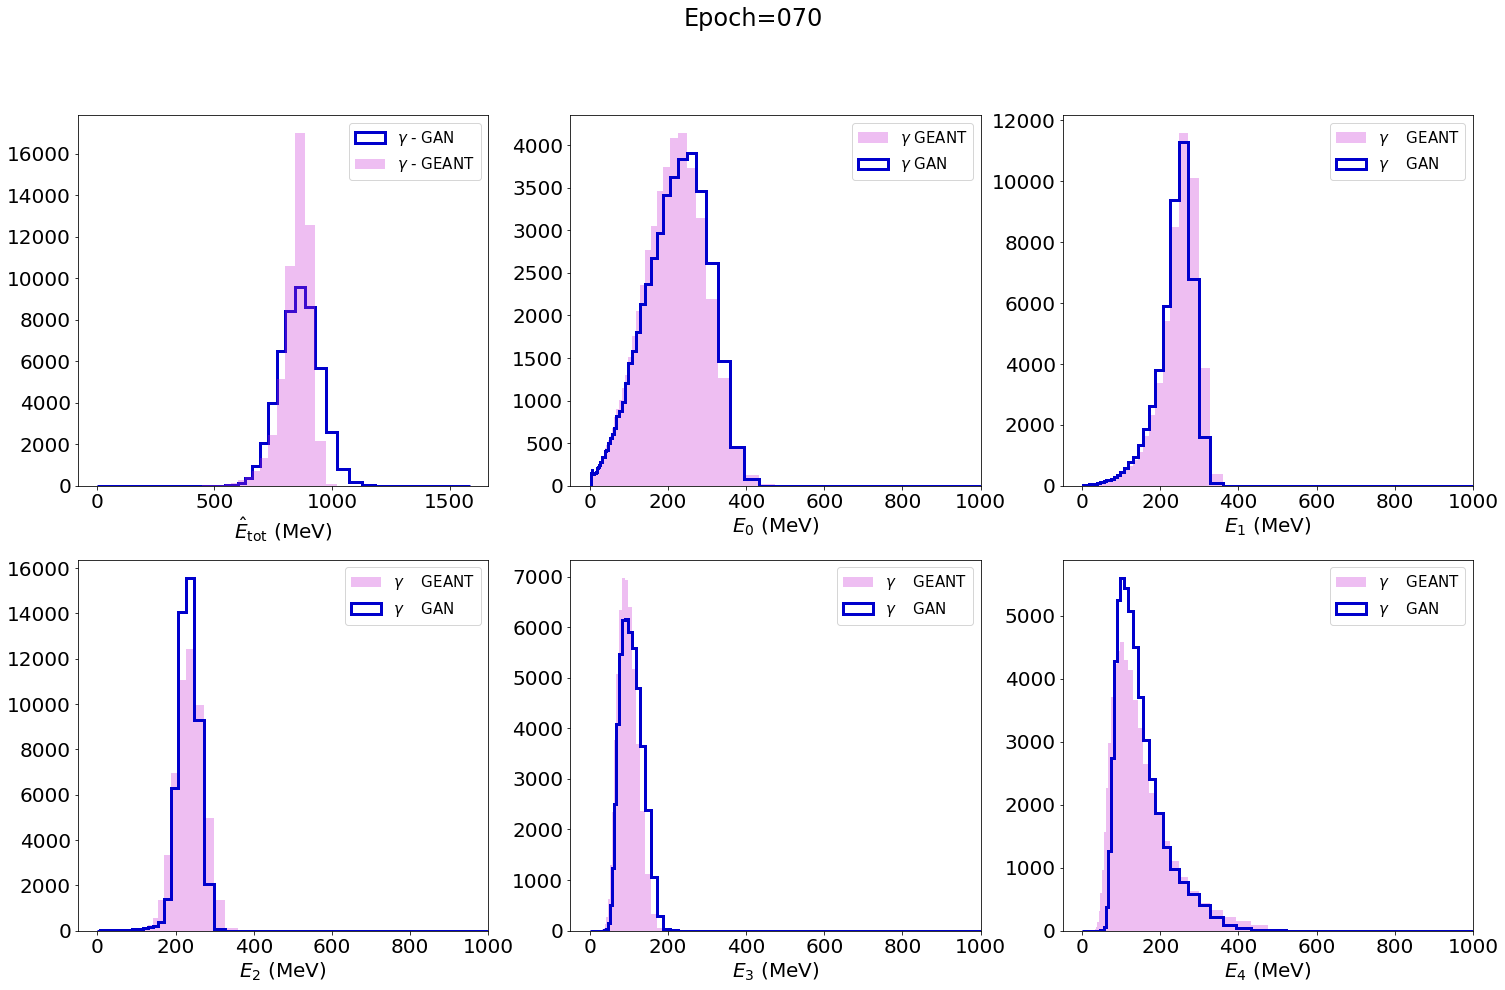

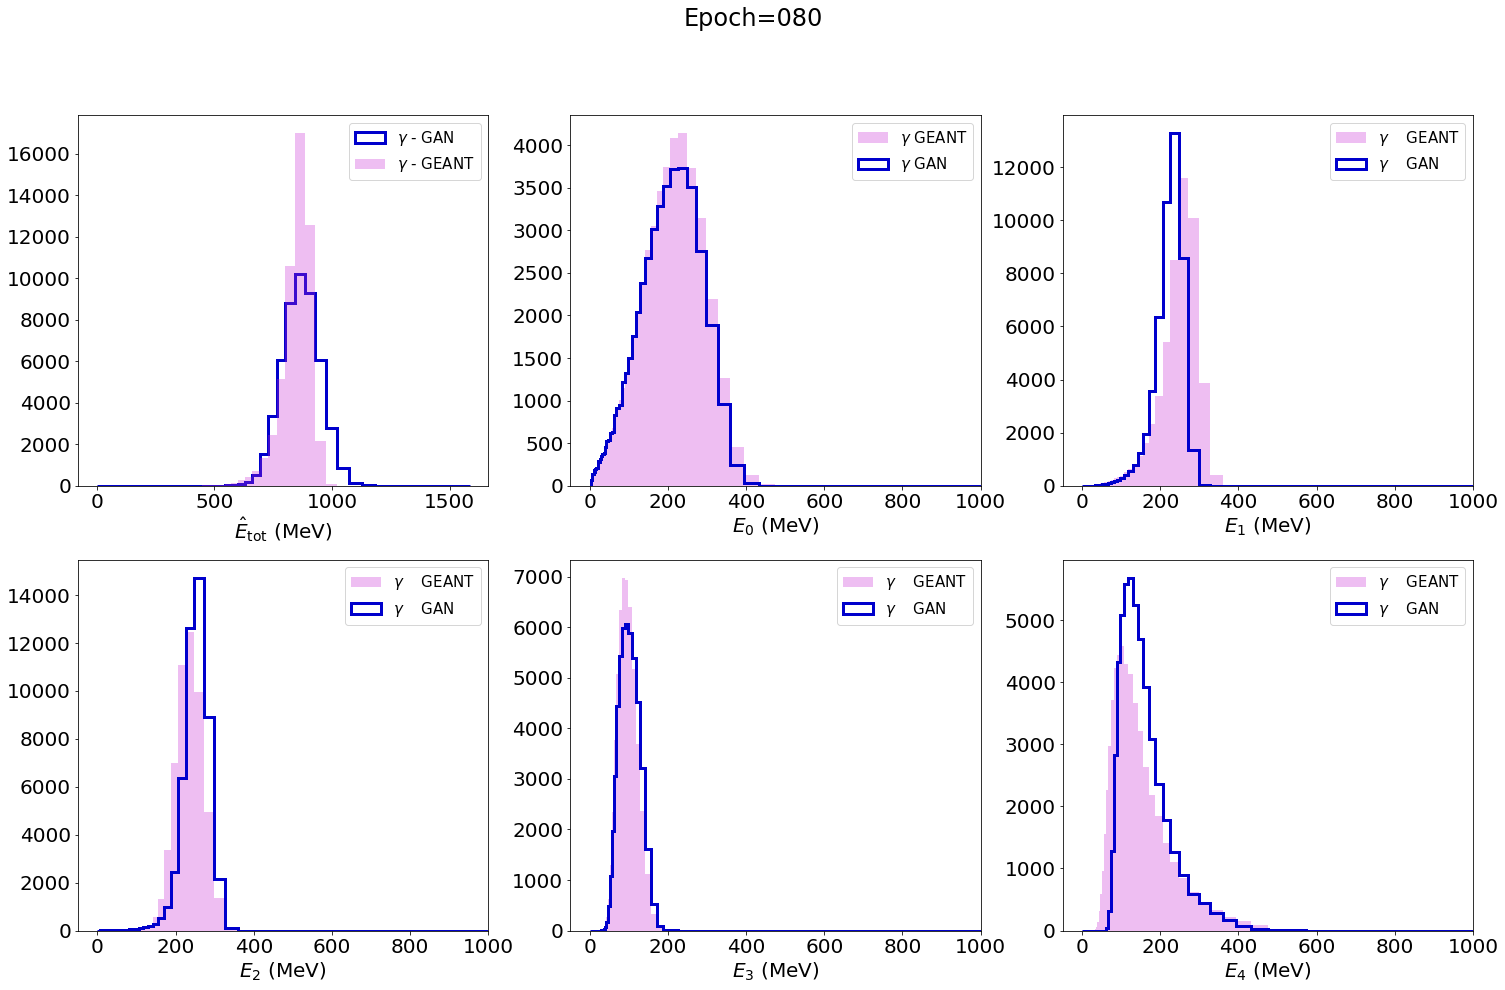

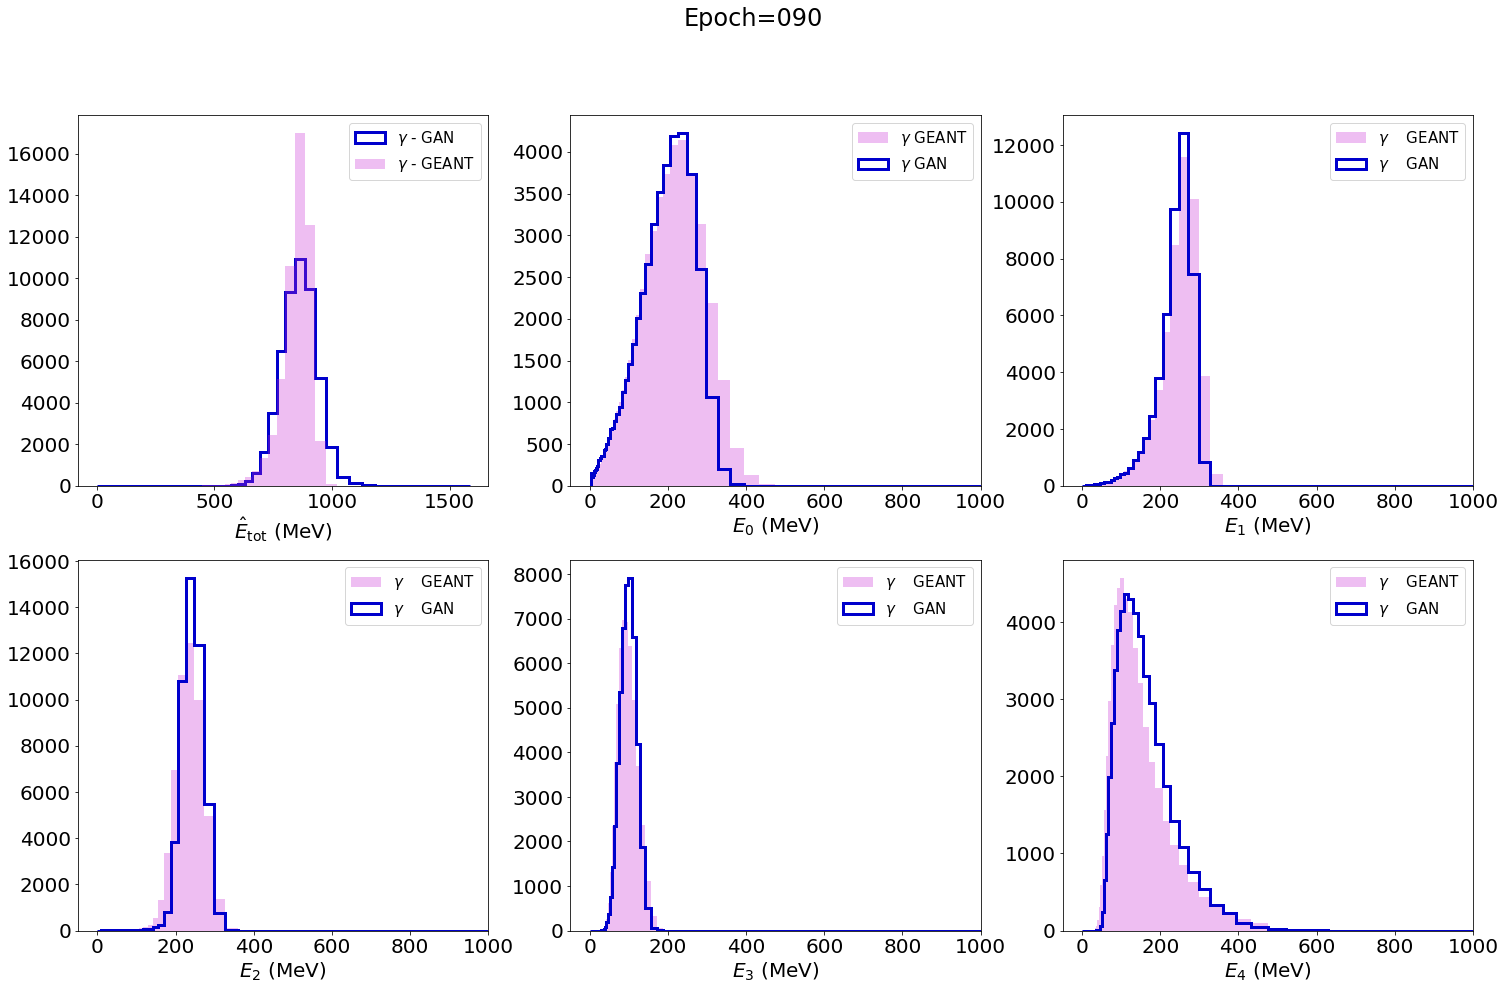

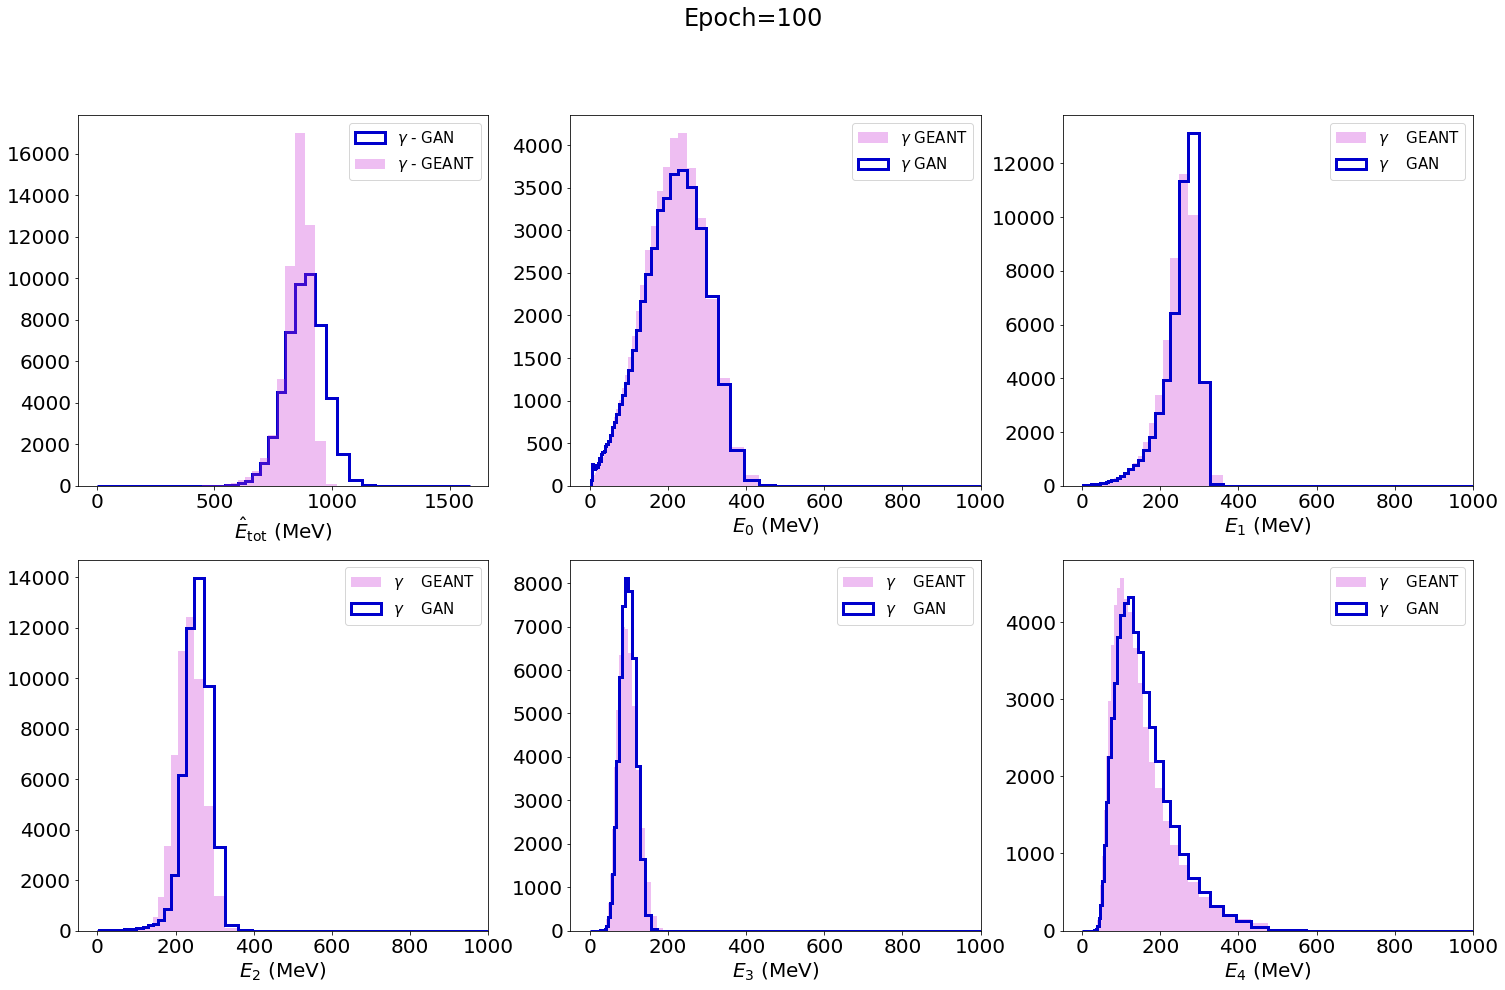

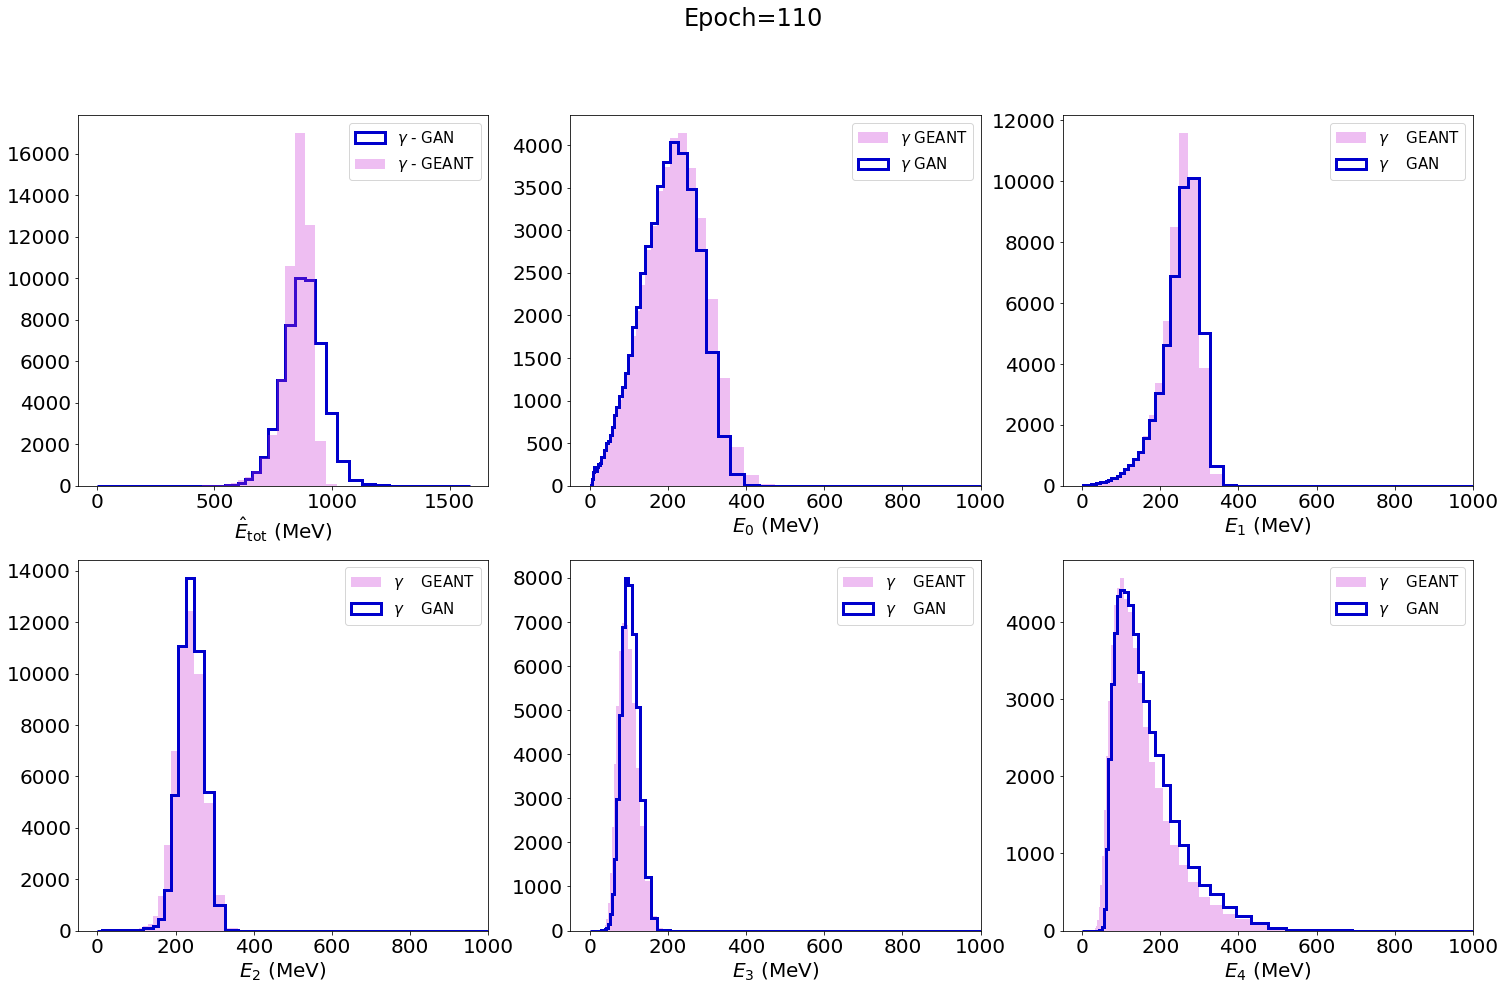

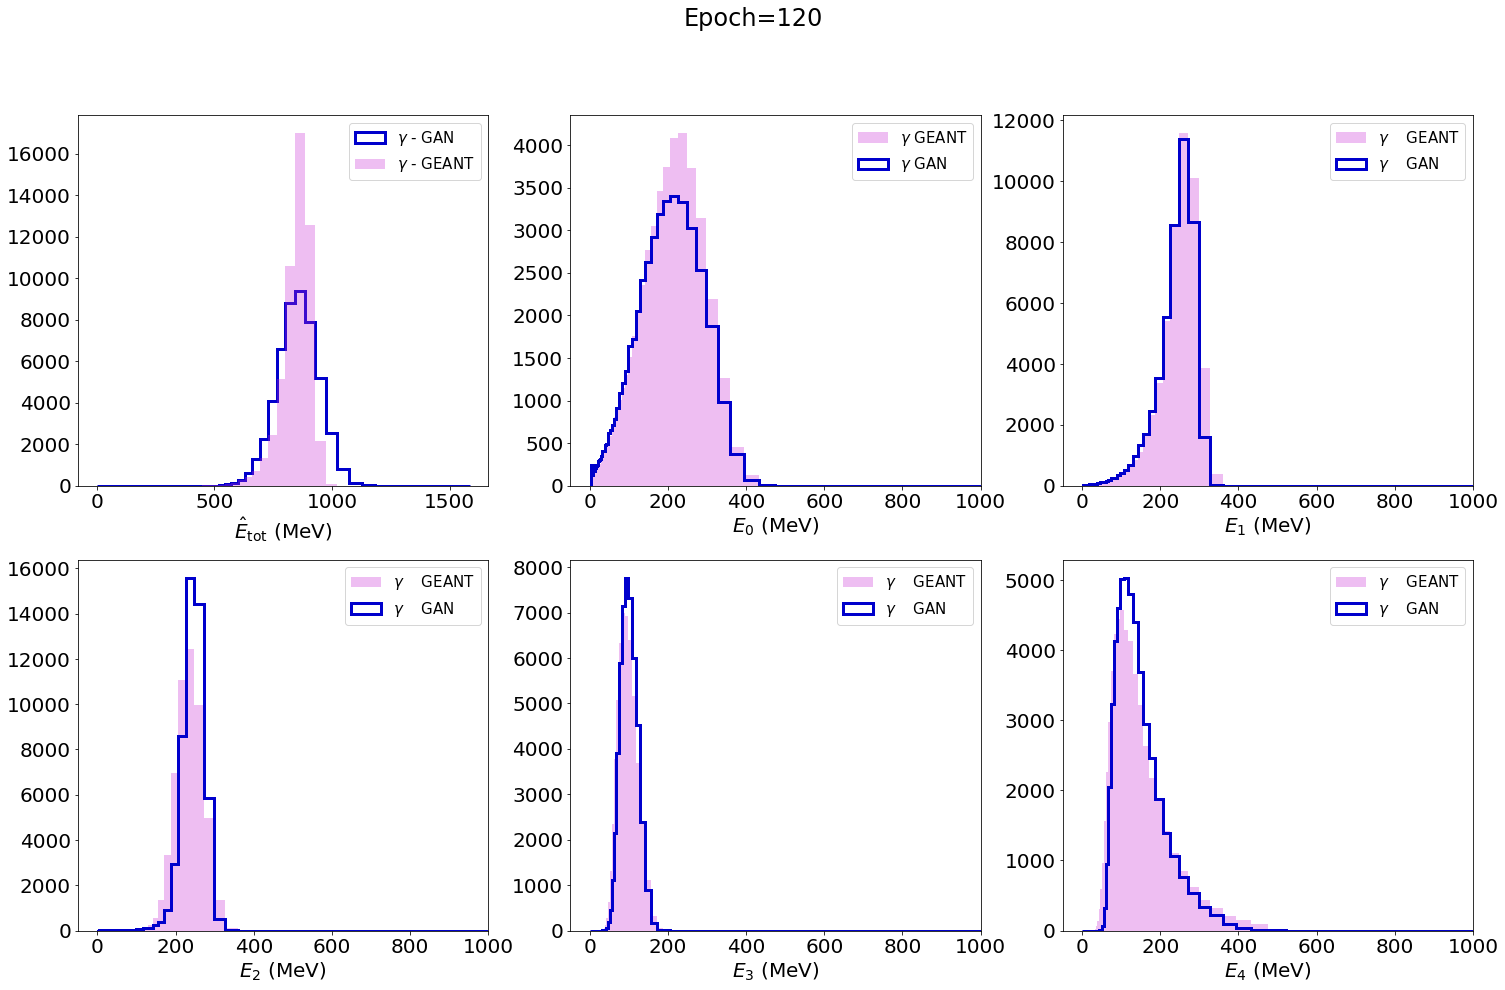

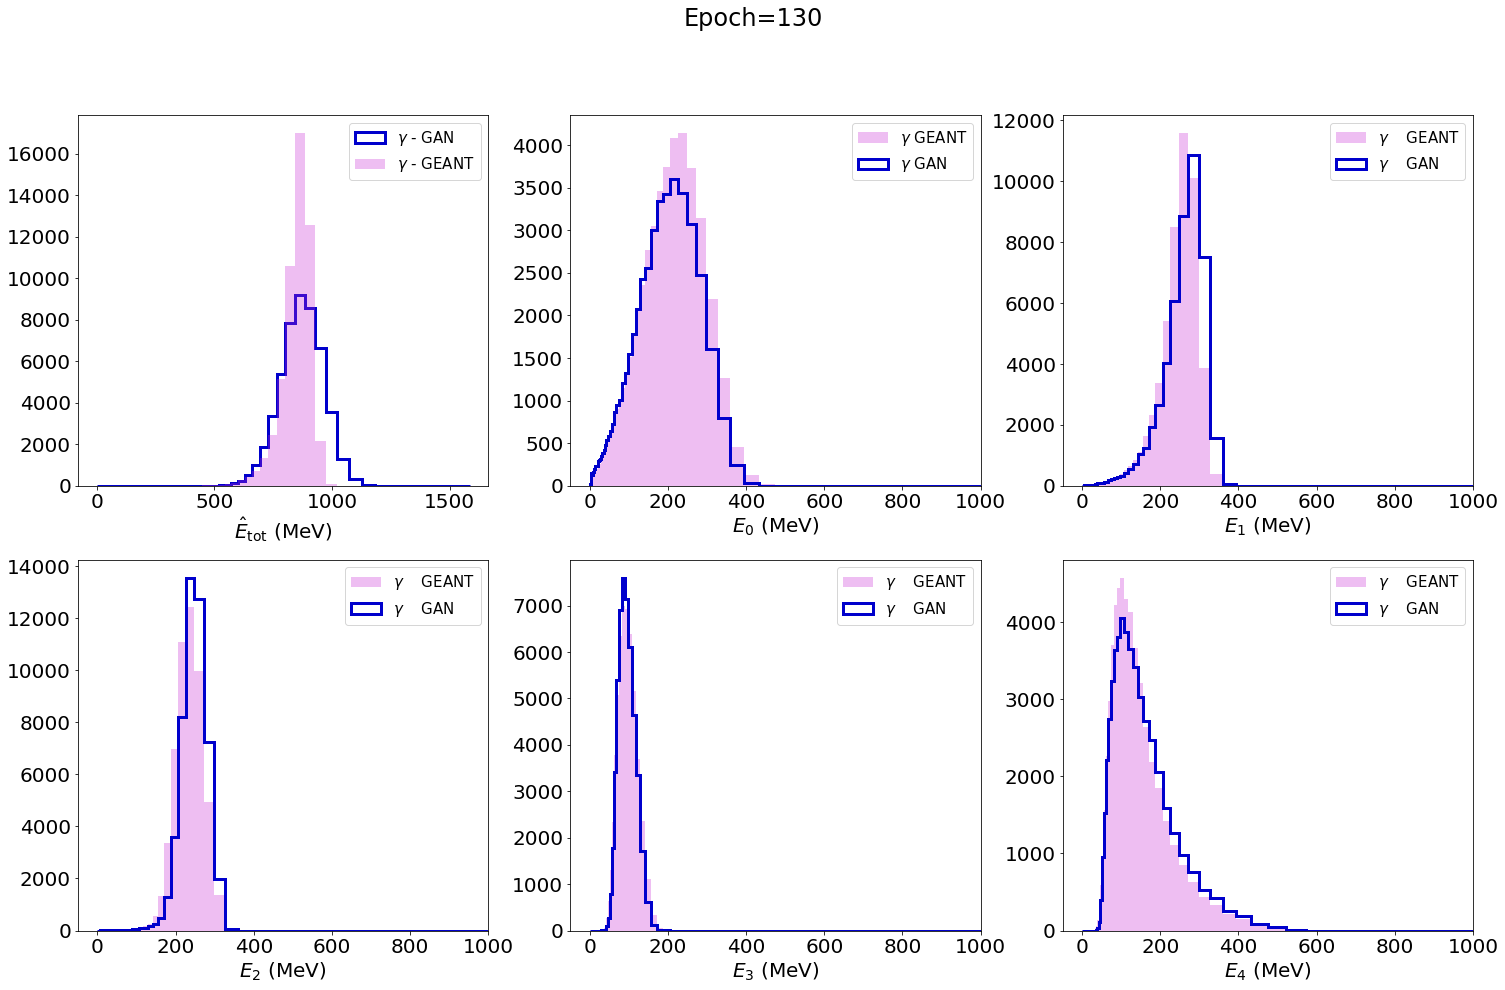

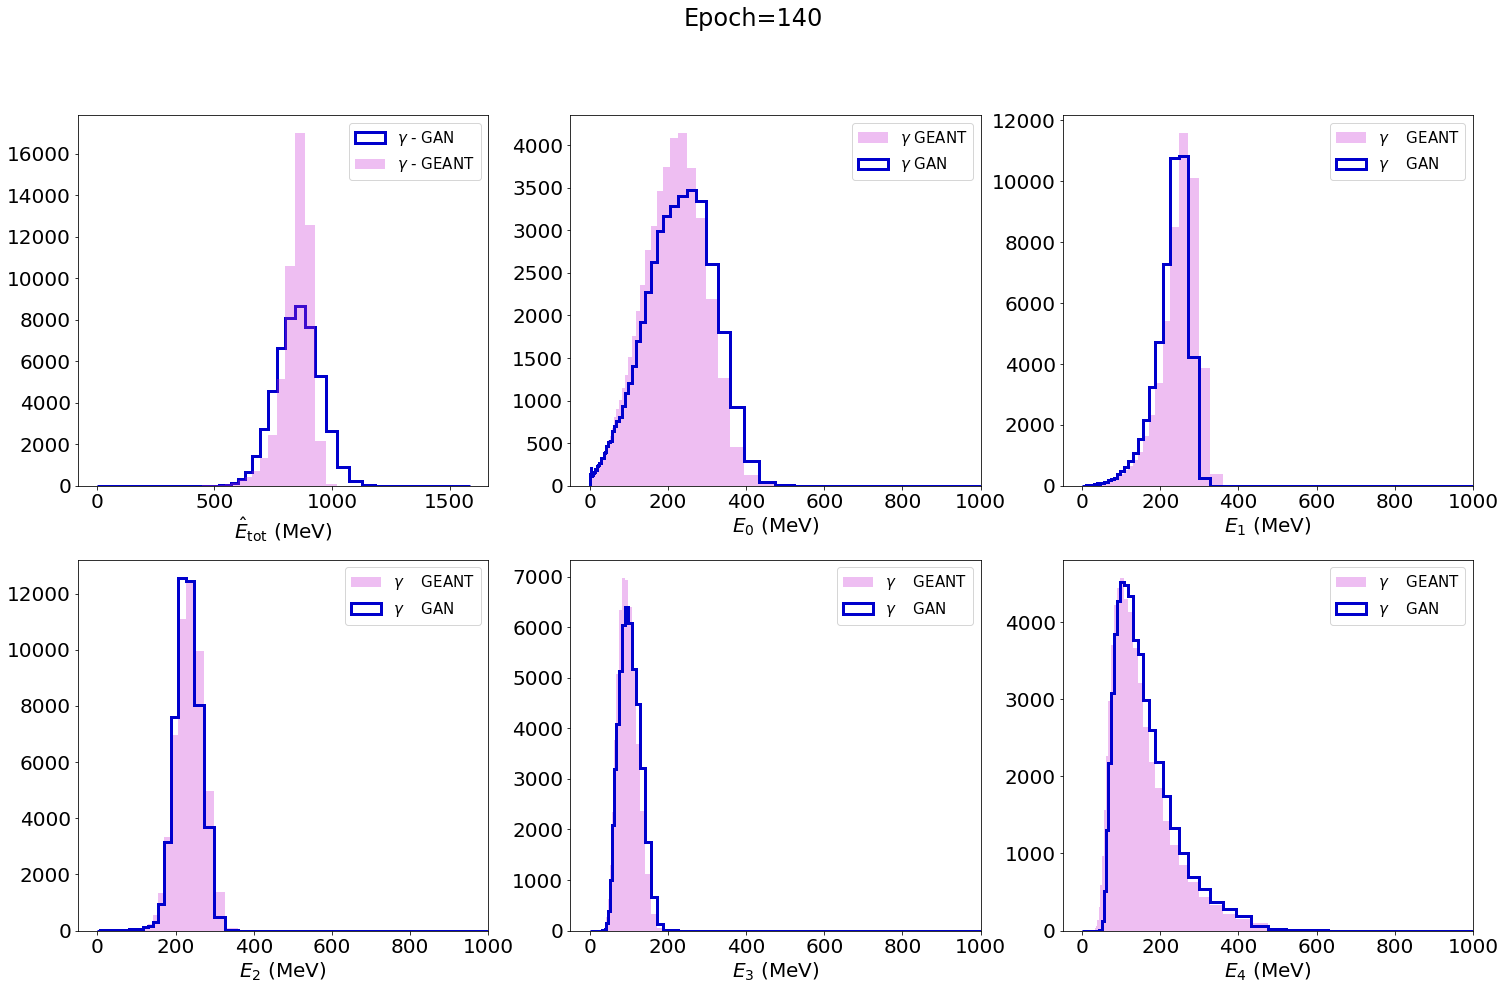

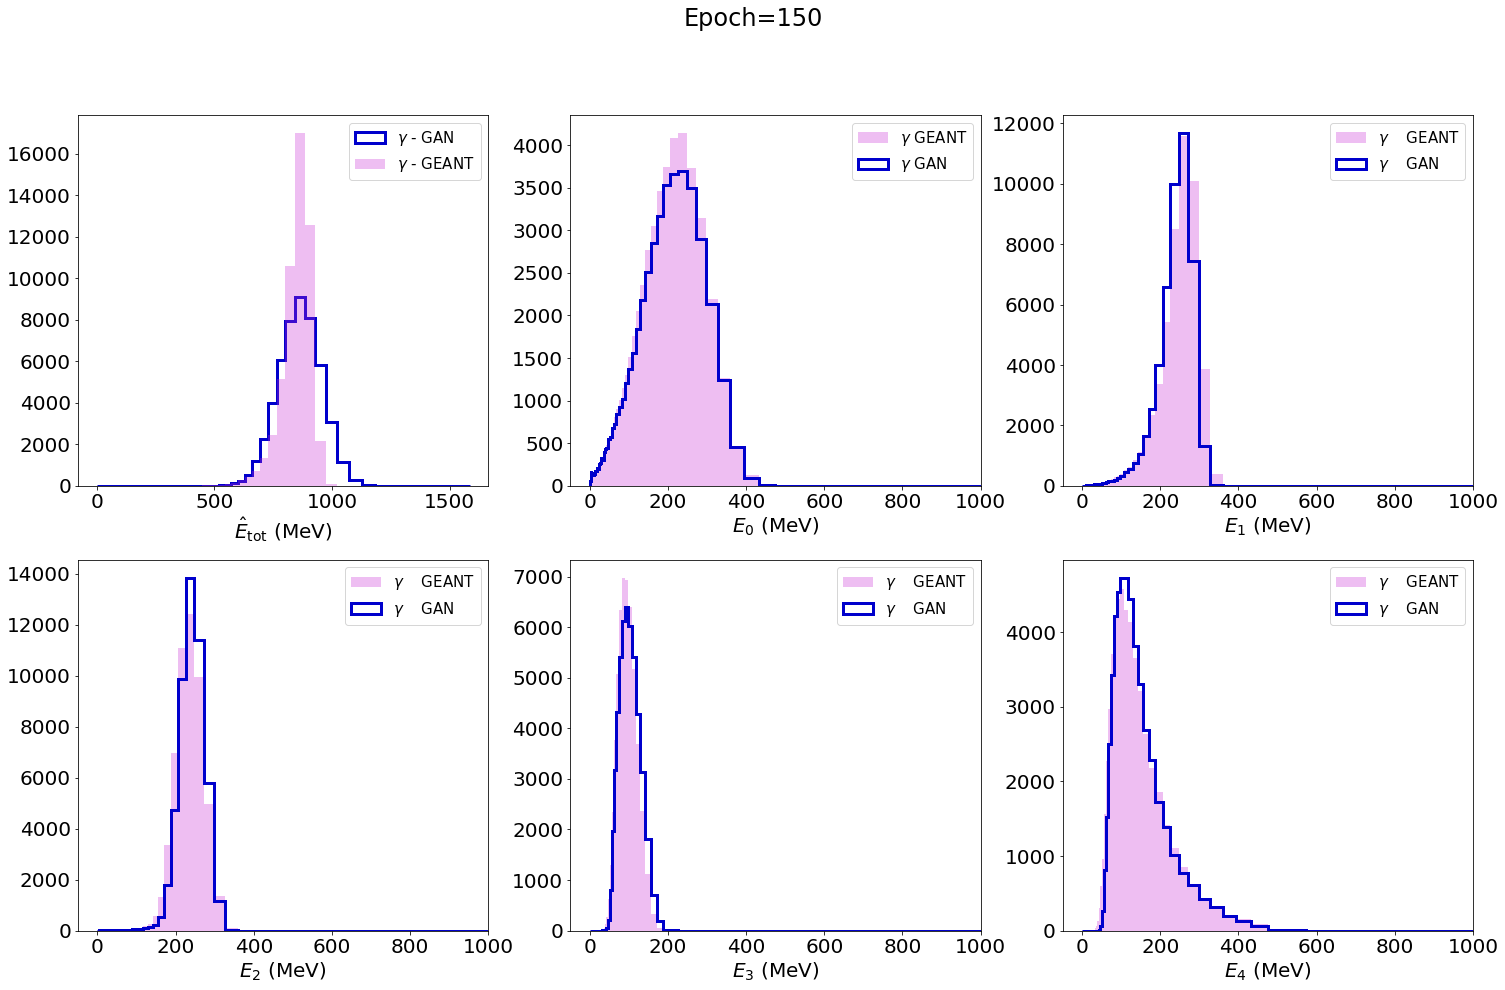

In [7]:
plt.rcParams.update({'font.size': 20})
colors = plt.cm.gnuplot2(np.linspace(0.2, 0.8, 3))

for eph in epochs:
    
    # input placeholders
    latent = Input(shape=(latent_size, ), name='z') # noise
    input_energy = Input(shape=(1, ), dtype='float32') # requested energy of the particle shower
    generator_inputs = [latent, input_energy]

    # multiply the (scaled) energy into the latent space
    h = Lambda(lambda x: x[0] * x[1])([latent, scale(input_energy, 100)])

    # build 5 LAGAN-style generators (checkout out `build_generator` in architectures.py)
    img_layer = []
    for i in range(5):
        img_layer.append(build_generator(h, 12, 12))

    # inpainting
    zero2one = AveragePooling2D(pool_size=(1, 1))(UpSampling2D(size=(1, 1))(img_layer[0]))
    img_layer[1] = inpainting_attention(img_layer[1], zero2one)
    for j in range(1,4):
        one2N = AveragePooling2D(pool_size=(1, 1))(img_layer[j])
        img_layer[j+1] = inpainting_attention(img_layer[j+1], one2N)

    generator_outputs = []

    ## outputs
    for k in range(5):
        generator_outputs.append(Activation('relu')(img_layer[k]))
        

    # build the actual model
    generator = Model(generator_inputs, generator_outputs)
    # load trained weights
    generator.load_weights('/home/eren/CaloGAN/data/{}'.format(eph))
    # 30,000 is the number of showers we want to generate right now
    noise = np.random.normal(0, 1, (50000, latent_size))
    sampled_energy = np.random.uniform(50, 50, (50000, 1))

    #sampled_energy25 = np.random.uniform(25, 25, (30000, 1))
    #sampled_energy75 = np.random.uniform(75, 75, (30000, 1))

    images = generator.predict([noise, sampled_energy], verbose=True)
    # we need to multiply images by 1000 to match order of magnitude of generated images to real images
    ## watch out for python3 changes: map method doesnt return list!
    images = list(map(lambda x: np.squeeze(x * 1000), images))
    
    
    dgen_gamma = {
    'layer_0': np.squeeze(images[0]),
    'layer_1': np.squeeze(images[1]),
    'layer_2': np.squeeze(images[2]),
    'layer_3': np.squeeze(images[3]),
    'layer_4': np.squeeze(images[4])
    }
    
    etot_gen_gamma = total_energy(dgen_gamma)
    etot_orig_gamma = total_energy(g)
    
    e0_orig_gamma = energy('0', g)
    e0_gen_gamma = energy('0', dgen_gamma)

    e1_orig_gamma = energy('1', g)
    e1_gen_gamma = energy('1', dgen_gamma)

    e2_orig_gamma = energy('2', g)
    e2_gen_gamma = energy('2', dgen_gamma)

    e3_orig_gamma = energy('3', g)
    e3_gen_gamma = energy('3', dgen_gamma)

    e4_orig_gamma = energy('4', g)
    e4_gen_gamma = energy('4', dgen_gamma)
    bins = np.linspace(0, 1500, 200)
        
    fig, axs = plt.subplots(2, 3, figsize=(25, 15))
    
   
    
    _ = axs[0][0].hist(etot_gen_gamma, bins=np.logspace(-1, 3.2, 200), histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$ - GAN')

    _ = axs[0][0].hist(etot_orig_gamma, bins=np.logspace(-1, 3.2, 200), histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$ - GEANT')
    axs[0][0].set_xlabel(r'$\hat{E}_\mathrm{tot}$ (MeV)')
    axs[0][0].legend(loc='upper right', fontsize=15, ncol=1)
    
    
   

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [1., 0., 1.]

    coeff, var_matrix = curve_fit(gauss, np.logspace(-1, 3.2, 200), e0_gen_gamma , p0=p0)
     
    
    _ = axs[0][1].hist(e0_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$ GEANT')
    _ = axs[0][1].hist(e0_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$ GAN')
    
    axs[0][1].set_xlabel(r'$E_0$ (MeV)')
    axs[0][1].legend(loc='upper right', fontsize=15, ncol=1)
    axs[0][1].set_xlim(xmax=1000)
    
    _ = axs[0][2].hist(e1_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$    GEANT')
    _ = axs[0][2].hist(e1_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$    GAN')
    
    axs[0][2].set_xlabel(r'$E_1$ (MeV)')
    axs[0][2].legend(loc='upper right', fontsize=15, ncol=1)
    axs[0][2].set_xlim(xmax=1000)
    
    _ = axs[1][0].hist(e2_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$    GEANT')
    _ = axs[1][0].hist(e2_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$    GAN')

    axs[1][0].set_xlabel(r'$E_2$ (MeV)')
    axs[1][0].legend(loc='upper right', fontsize=15, ncol=1)
    axs[1][0].set_xlim(xmax=1000)
    
    _ = axs[1][1].hist(e3_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$    GEANT')
    _ = axs[1][1].hist(e3_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$    GAN')
    
    axs[1][1].set_xlabel(r'$E_3$ (MeV)')
    axs[1][1].legend(loc='upper right', fontsize=15, ncol=1)
    axs[1][1].set_xlim(xmax=1000)
    
    _ = axs[1][2].hist(e4_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$    GEANT')
    _ = axs[1][2].hist(e4_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$    GAN')

    axs[1][2].set_xlabel(r'$E_4$ (MeV)')
    axs[1][2].legend(loc='upper right', fontsize=15, ncol=1)
    axs[1][2].set_xlim(xmax=1000)
    
    #plt.yscale('log')
    #plt.xscale('log')
    #plt.xlim(xmax=1500)
    #plt.xlabel(r'$\hat{E}_\mathrm{tot}$ (MeV)')
    fig.suptitle("Epoch={}".format(eph.split('_')[-1][5:8]))
    fig.savefig('shower-shapes/modified-Disc/Energy-{}.pdf'.format(eph.split('_')[-1].split('.')[0]))


In [8]:
etot_orig_gamma = total_energy(g)

In [17]:
m, s = stats.norm.fit(etot_orig_gamma)

In [15]:
stats.norm.stats()

(array(0.), array(1.))

In [14]:
(92.01/853.06) * 100.00 

10.785876726138843

In [13]:
844.00 / 50000

0.01688

[   14   173  1031  4850 11740 15903 11310  4219   703    57] [  3.74165739  13.15294644  32.10918872  69.64194139 108.35128056
 126.10709734 106.34848377  64.95382976  26.51414717   7.54983444]
Fitted mean =  852.9896767300191 +/- 1.272836355984976
Fitted standard deviation =  94.21894424341798 +/- 0.8998058719025009


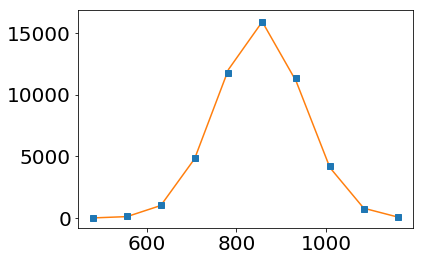

In [103]:

hist, bin_edges = np.histogram(etot_gen_gamma)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

p0 = [500., 800.4904, 80]
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

print (hist, np.sqrt(hist))



coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0, sigma=np.sqrt(hist))
# Get the fitted curve
hist_fit = gauss(bin_centres, *coeff)

#plt.plot(bin_centres, hist, 'bo', label='Test data')
plt.errorbar(bin_centres, hist, yerr=np.sqrt(hist), marker='s', ls='None')
plt.plot(bin_centres, hist_fit, label='Fitted data')

#plt.ylim(ymax=5500, ymin=4300)
## error of the parameter
e = np.sqrt(np.diag(var_matrix))

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print ('Fitted mean = ', coeff[1], '+/-', e[1])
print ('Fitted standard deviation = ',coeff[2],'+/-', e[2])


In [68]:
np.sqrt(hist)

array([0.00192804, 0.0067776 , 0.01654558, 0.03588588, 0.05583246,
       0.06498188, 0.05480044, 0.03347014, 0.01366251, 0.00389036])

In [55]:
np.sqrt(np.diag(var_matrix))

array([2.12840655e-05, 5.52653832e-01, 5.52619564e-01])